In [207]:
import pandas as pd 
import pandas as pd
import numpy as np
import os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn import metrics
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE


import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import pearsonr
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import BorderlineSMOTE

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.model_selection import cross_validate
from statistics import mean
import pickle

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# pd.set_option('max_rows', None)
# pd.set_option('max_columns', None)
# pd.set_option('max_colwidth', None)
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [208]:
%run utils.ipynb

In [209]:
df = pd.read_csv('credit.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)


In [210]:
df 

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,age,installment_plan,housing,existing_credits,default,dependents,telephone,foreign_worker,job,gender
0,-43.0,6,critical,radio/tv,1169,NaN,13 years,4,single,none,...,67,none,own,2,0,1,2.349340e+09,yes,skilled employee,male
1,75.0,48,repaid,radio/tv,5951,89.0,2 years,2,NaN,none,...,22,none,own,1,1,1,NaN,yes,skilled employee,female
2,NaN,12,critical,education,2096,24.0,5 years,2,single,none,...,49,none,own,1,0,2,NaN,yes,unskilled resident,male
3,-32.0,42,repaid,furniture,7882,9.0,5 years,2,single,guarantor,...,45,none,for free,1,0,2,NaN,yes,skilled employee,male
4,-23.0,24,delayed,car (new),4870,43.0,3 years,3,single,none,...,53,none,for free,2,1,2,NaN,yes,skilled employee,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,12,repaid,furniture,1736,48.0,4 years,3,NaN,none,...,31,none,own,1,0,1,NaN,yes,unskilled resident,female
996,-30.0,30,repaid,car (used),3857,20.0,3 years,4,divorced,none,...,40,none,own,1,0,1,2.340004e+09,yes,mangement self-employed,male
997,NaN,12,repaid,radio/tv,804,44.0,13 years,4,single,none,...,38,none,own,1,0,1,NaN,yes,skilled employee,male
998,-18.0,45,repaid,radio/tv,1845,31.0,2 years,4,single,none,...,23,none,for free,1,1,1,2.342257e+09,yes,skilled employee,male


In [211]:
df.columns

Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'employment_length', 'installment_rate',
       'personal_status', 'other_debtors', 'residence_history', 'property',
       'age', 'installment_plan', 'housing', 'existing_credits', 'default',
       'dependents', 'telephone', 'foreign_worker', 'job', 'gender'],
      dtype='object')

In [212]:
df['IsDefault'] = df['default'].apply(lambda x: 'Good' if x == 0 else 'Bad')


In [213]:
# Segregate columns by data type
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Display the segregated columns
numeric_cols, categorical_cols


(['checking_balance',
  'months_loan_duration',
  'amount',
  'savings_balance',
  'installment_rate',
  'age',
  'existing_credits',
  'default',
  'dependents',
  'telephone'],
 ['credit_history',
  'purpose',
  'employment_length',
  'personal_status',
  'other_debtors',
  'residence_history',
  'property',
  'installment_plan',
  'housing',
  'foreign_worker',
  'job',
  'gender',
  'IsDefault'])

### Handling Missing values

In [214]:
def audit_missing_data(df):

    # Calculate the percentage of missing values for each column
    missing_percentage = df.isnull().mean() * 100
    
    # Convert to a DataFrame for readability
    missing_df = missing_percentage.reset_index()
    missing_df.columns = ['Column', 'MissingPercentage']
    
    # Sort by MissingPercentage in descending order for easier analysis
    missing_df = missing_df.sort_values(by='MissingPercentage', ascending=False)
    
    return missing_df

# Apply the audit method to the data
missing_data_audit = audit_missing_data(df)
missing_data_audit


,Column,MissingPercentage
18,telephone,59.6
0,checking_balance,39.4
8,personal_status,31.0
5,savings_balance,18.3
10,residence_history,13.0
6,employment_length,6.2
14,housing,0.0
21,gender,0.0
20,job,0.0
19,foreign_worker,0.0


Telephone is a redandant variables, we cant use it while modeling so no need to consider it during the process

In [215]:
# Drop the 'telephone' column
df = df.drop('telephone', axis=1)


Filling the Missing values according to the variable nature. We will cater the outliers and missing values in Fine and Coarse classing as well

In [216]:
# Null imputation
df['checking_balance'].fillna(0, inplace=True)
df['savings_balance'].fillna(0, inplace=True)
df['personal_status'].fillna("Unknown", inplace=True)
df['residence_history'].fillna("Unknown", inplace=True)
df['employment_length'].fillna("Unknown", inplace=True)

# Verify the changes by checking for null values again
audit_missing_data_after_imputation = audit_missing_data(df=df)
audit_missing_data_after_imputation


,Column,MissingPercentage
0,checking_balance,0.0
1,months_loan_duration,0.0
20,gender,0.0
19,job,0.0
18,foreign_worker,0.0
17,dependents,0.0
16,default,0.0
15,existing_credits,0.0
14,housing,0.0
13,installment_plan,0.0


#### Data Prepartion - Numerical Variables

In [217]:
list(df.columns)

['checking_balance',
 'months_loan_duration',
 'credit_history',
 'purpose',
 'amount',
 'savings_balance',
 'employment_length',
 'installment_rate',
 'personal_status',
 'other_debtors',
 'residence_history',
 'property',
 'age',
 'installment_plan',
 'housing',
 'existing_credits',
 'default',
 'dependents',
 'foreign_worker',
 'job',
 'gender',
 'IsDefault']

In [218]:
df.to_excel('fixed_credit_data.xlsx')

In [219]:
# Specify the columns for binning
columns_to_bin = ['checking_balance',
  'months_loan_duration',
  'amount',
  'savings_balance',
  'installment_rate',
  'age',
  'existing_credits',
  'default'] 
  
  # Apply binning with 4 bins for each specified column
for col in columns_to_bin:
    df[col+'_binned'] = pd.qcut(df[col], q=4, duplicates='drop')

df 


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,gender,IsDefault,checking_balance_binned,months_loan_duration_binned,amount_binned,savings_balance_binned,installment_rate_binned,age_binned,existing_credits_binned,default_binned
0,-43.0,6,critical,radio/tv,1169,0.0,13 years,4,single,none,...,male,Good,"(-50.001, -5.25]","(3.999, 12.0]","(249.999, 1365.5]","(-0.001, 10.75]","(3.0, 4.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]"
1,75.0,48,repaid,radio/tv,5951,89.0,2 years,2,Unknown,none,...,female,Bad,"(67.0, 999.0]","(24.0, 72.0]","(3972.25, 18424.0]","(49.5, 91.25]","(0.999, 2.0]","(18.999, 27.0]","(0.999, 2.0]","(-0.001, 1.0]"
2,0.0,12,critical,education,2096,24.0,5 years,2,single,none,...,male,Good,"(-5.25, 0.0]","(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]"
3,-32.0,42,repaid,furniture,7882,9.0,5 years,2,single,guarantor,...,male,Good,"(-50.001, -5.25]","(24.0, 72.0]","(3972.25, 18424.0]","(-0.001, 10.75]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]"
4,-23.0,24,delayed,car (new),4870,43.0,3 years,3,single,none,...,male,Bad,"(-50.001, -5.25]","(18.0, 24.0]","(3972.25, 18424.0]","(10.75, 49.5]","(2.0, 3.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,12,repaid,furniture,1736,48.0,4 years,3,Unknown,none,...,female,Good,"(-5.25, 0.0]","(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(2.0, 3.0]","(27.0, 33.0]","(0.999, 2.0]","(-0.001, 1.0]"
996,-30.0,30,repaid,car (used),3857,20.0,3 years,4,divorced,none,...,male,Good,"(-50.001, -5.25]","(24.0, 72.0]","(2319.5, 3972.25]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]","(-0.001, 1.0]"
997,0.0,12,repaid,radio/tv,804,44.0,13 years,4,single,none,...,male,Good,"(-5.25, 0.0]","(3.999, 12.0]","(249.999, 1365.5]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]","(-0.001, 1.0]"
998,-18.0,45,repaid,radio/tv,1845,31.0,2 years,4,single,none,...,male,Bad,"(-50.001, -5.25]","(24.0, 72.0]","(1365.5, 2319.5]","(10.75, 49.5]","(3.0, 4.0]","(18.999, 27.0]","(0.999, 2.0]","(-0.001, 1.0]"


#### Data Prepartion - Catagorical Variables

In [220]:
cols_to_bin = ['credit_history',
  'purpose',
  'employment_length',
  'personal_status',
  'other_debtors',
  'residence_history',
  'property',
  'installment_plan',
  'housing',
  'foreign_worker',
  'job',
  'gender',
  'IsDefault']

In [221]:
df['employment_length'].unique().tolist()

['13 years',
 '2 years',
 '5 years',
 '3 years',
 '11 years',
 '4 years',
 'Unknown',
 '6 months',
 '5 months',
 '16 years',
 '1 years',
 '17 years',
 '3 months',
 '9 years',
 '4 months',
 '10 years',
 '10 months',
 '1 months',
 '7 months',
 '19 years',
 '7 years',
 '14 years',
 '18 years',
 '0 months',
 '15 years',
 '9 months',
 '6 years',
 '8 years',
 '12 years',
 '11 months',
 '2 months',
 '8 months']

In [222]:
import numpy as np

# Helper function to convert employment length to numeric years
def employment_length_to_years(s):
    if 'year' in s:
        return int(s.split()[0])
    elif 'month' in s:
        return int(s.split()[0]) / 12
    return np.nan

# Convert employment_length to numeric years, treating "Unknown" as NaN for now
df['employment_length_years'] = df['employment_length'].apply(lambda x: employment_length_to_years(x) if x != "Unknown" else np.nan)

# Now, categorize these into 5 bins
bins = [-np.inf, 0, 5, 10, 15, np.inf]
labels = ['0 years', '< 5 years', '5-10 years', '10-15 years', '> 15 years']
df['employment_length_binned'] = pd.cut(df['employment_length_years'], bins=bins, labels=labels)

# Add "Unknown" to the categories of the binned column
df['employment_length_binned'] = df['employment_length_binned'].cat.add_categories(['Unknown'])

# Now fill NaN values with "Unknown"
df['employment_length_binned'].fillna('Unknown', inplace=True)
df



,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,checking_balance_binned,months_loan_duration_binned,amount_binned,savings_balance_binned,installment_rate_binned,age_binned,existing_credits_binned,default_binned,employment_length_years,employment_length_binned
0,-43.0,6,critical,radio/tv,1169,0.0,13 years,4,single,none,...,"(-50.001, -5.25]","(3.999, 12.0]","(249.999, 1365.5]","(-0.001, 10.75]","(3.0, 4.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",13.0,10-15 years
1,75.0,48,repaid,radio/tv,5951,89.0,2 years,2,Unknown,none,...,"(67.0, 999.0]","(24.0, 72.0]","(3972.25, 18424.0]","(49.5, 91.25]","(0.999, 2.0]","(18.999, 27.0]","(0.999, 2.0]","(-0.001, 1.0]",2.0,< 5 years
2,0.0,12,critical,education,2096,24.0,5 years,2,single,none,...,"(-5.25, 0.0]","(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",5.0,< 5 years
3,-32.0,42,repaid,furniture,7882,9.0,5 years,2,single,guarantor,...,"(-50.001, -5.25]","(24.0, 72.0]","(3972.25, 18424.0]","(-0.001, 10.75]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",5.0,< 5 years
4,-23.0,24,delayed,car (new),4870,43.0,3 years,3,single,none,...,"(-50.001, -5.25]","(18.0, 24.0]","(3972.25, 18424.0]","(10.75, 49.5]","(2.0, 3.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",3.0,< 5 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,12,repaid,furniture,1736,48.0,4 years,3,Unknown,none,...,"(-5.25, 0.0]","(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(2.0, 3.0]","(27.0, 33.0]","(0.999, 2.0]","(-0.001, 1.0]",4.0,< 5 years
996,-30.0,30,repaid,car (used),3857,20.0,3 years,4,divorced,none,...,"(-50.001, -5.25]","(24.0, 72.0]","(2319.5, 3972.25]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]","(-0.001, 1.0]",3.0,< 5 years
997,0.0,12,repaid,radio/tv,804,44.0,13 years,4,single,none,...,"(-5.25, 0.0]","(3.999, 12.0]","(249.999, 1365.5]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]","(-0.001, 1.0]",13.0,10-15 years
998,-18.0,45,repaid,radio/tv,1845,31.0,2 years,4,single,none,...,"(-50.001, -5.25]","(24.0, 72.0]","(1365.5, 2319.5]","(10.75, 49.5]","(3.0, 4.0]","(18.999, 27.0]","(0.999, 2.0]","(-0.001, 1.0]",2.0,< 5 years


In [223]:
df['residence_history'].unique().tolist()

['6 years',
 '5 months',
 '4 years',
 '13 years',
 '8 years',
 '12 years',
 '3 months',
 '24 years',
 '10 months',
 'Unknown',
 '10 years',
 '19 years',
 '0 months',
 '7 years',
 '3 years',
 '8 months',
 '7 months',
 '14 years',
 '1 years',
 '16 years',
 '6 months',
 '2 years',
 '20 years',
 '11 months',
 '21 years',
 '5 years',
 '9 months',
 '2 months',
 '15 years',
 '11 years',
 '18 years',
 '22 years',
 '23 years',
 '1 months',
 '9 years',
 '4 months',
 '17 years']

In [224]:
# Convert residence_history to numeric years, treating "Unknown" as NaN for now
df['residence_history_years'] = df['residence_history'].apply(lambda x: employment_length_to_years(x) if x != "Unknown" else np.nan)

# Categorize these into 5 bins
df['residence_history_binned'] = pd.cut(df['residence_history_years'], bins=bins, labels=labels)

# Add "Unknown" to the categories of the binned column and fill NaN values
df['residence_history_binned'] = df['residence_history_binned'].cat.add_categories(['Unknown'])
df['residence_history_binned'].fillna('Unknown', inplace=True)
df


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,amount_binned,savings_balance_binned,installment_rate_binned,age_binned,existing_credits_binned,default_binned,employment_length_years,employment_length_binned,residence_history_years,residence_history_binned
0,-43.0,6,critical,radio/tv,1169,0.0,13 years,4,single,none,...,"(249.999, 1365.5]","(-0.001, 10.75]","(3.0, 4.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",13.0,10-15 years,6.000000,5-10 years
1,75.0,48,repaid,radio/tv,5951,89.0,2 years,2,Unknown,none,...,"(3972.25, 18424.0]","(49.5, 91.25]","(0.999, 2.0]","(18.999, 27.0]","(0.999, 2.0]","(-0.001, 1.0]",2.0,< 5 years,0.416667,< 5 years
2,0.0,12,critical,education,2096,24.0,5 years,2,single,none,...,"(1365.5, 2319.5]","(10.75, 49.5]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",5.0,< 5 years,4.000000,< 5 years
3,-32.0,42,repaid,furniture,7882,9.0,5 years,2,single,guarantor,...,"(3972.25, 18424.0]","(-0.001, 10.75]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",5.0,< 5 years,13.000000,10-15 years
4,-23.0,24,delayed,car (new),4870,43.0,3 years,3,single,none,...,"(3972.25, 18424.0]","(10.75, 49.5]","(2.0, 3.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",3.0,< 5 years,13.000000,10-15 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,12,repaid,furniture,1736,48.0,4 years,3,Unknown,none,...,"(1365.5, 2319.5]","(10.75, 49.5]","(2.0, 3.0]","(27.0, 33.0]","(0.999, 2.0]","(-0.001, 1.0]",4.0,< 5 years,20.000000,> 15 years
996,-30.0,30,repaid,car (used),3857,20.0,3 years,4,divorced,none,...,"(2319.5, 3972.25]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]","(-0.001, 1.0]",3.0,< 5 years,5.000000,< 5 years
997,0.0,12,repaid,radio/tv,804,44.0,13 years,4,single,none,...,"(249.999, 1365.5]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]","(-0.001, 1.0]",13.0,10-15 years,16.000000,> 15 years
998,-18.0,45,repaid,radio/tv,1845,31.0,2 years,4,single,none,...,"(1365.5, 2319.5]","(10.75, 49.5]","(3.0, 4.0]","(18.999, 27.0]","(0.999, 2.0]","(-0.001, 1.0]",2.0,< 5 years,8.000000,5-10 years


In [225]:
df.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['checking_balance', 'months_loan_duration', 'credit_history', 'purpose',
       'amount', 'savings_balance', 'employment_length', 'installment_rate',
       'personal_status', 'other_debtors', 'residence_history', 'property',
       'age', 'installment_plan', 'housing', 'existing_credits', 'default',
       'dependents', 'foreign_worker', 'job', 'gender', 'IsDefault',
       'checking_balance_binned', 'months_loan_duration_binned',
       'amount_binned', 'savings_balance_binned', 'installment_rate_binned',
       'age_binned', 'existing_credits_binned', 'default_binned',
       'employment_length_years', 'employment_length_binned',
       'residence_history_years', 'residence_history_binned'],
      dtype='object')>

#### EDA

In [226]:
cols_to_check = ['credit_history', 'purpose', 'personal_status', 'other_debtors',
                 'property', 'installment_plan', 'housing',
       'foreign_worker', 'job', 'gender',  'checking_balance_binned', 'months_loan_duration_binned',
       'amount_binned', 'savings_balance_binned', 'installment_rate_binned', 'age_binned', 
       'existing_credits_binned', 'dependents', 
       'employment_length_binned',  'residence_history_binned']

In [227]:
df 


,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_length,installment_rate,personal_status,other_debtors,...,amount_binned,savings_balance_binned,installment_rate_binned,age_binned,existing_credits_binned,default_binned,employment_length_years,employment_length_binned,residence_history_years,residence_history_binned
0,-43.0,6,critical,radio/tv,1169,0.0,13 years,4,single,none,...,"(249.999, 1365.5]","(-0.001, 10.75]","(3.0, 4.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",13.0,10-15 years,6.000000,5-10 years
1,75.0,48,repaid,radio/tv,5951,89.0,2 years,2,Unknown,none,...,"(3972.25, 18424.0]","(49.5, 91.25]","(0.999, 2.0]","(18.999, 27.0]","(0.999, 2.0]","(-0.001, 1.0]",2.0,< 5 years,0.416667,< 5 years
2,0.0,12,critical,education,2096,24.0,5 years,2,single,none,...,"(1365.5, 2319.5]","(10.75, 49.5]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",5.0,< 5 years,4.000000,< 5 years
3,-32.0,42,repaid,furniture,7882,9.0,5 years,2,single,guarantor,...,"(3972.25, 18424.0]","(-0.001, 10.75]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",5.0,< 5 years,13.000000,10-15 years
4,-23.0,24,delayed,car (new),4870,43.0,3 years,3,single,none,...,"(3972.25, 18424.0]","(10.75, 49.5]","(2.0, 3.0]","(42.0, 75.0]","(0.999, 2.0]","(-0.001, 1.0]",3.0,< 5 years,13.000000,10-15 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,12,repaid,furniture,1736,48.0,4 years,3,Unknown,none,...,"(1365.5, 2319.5]","(10.75, 49.5]","(2.0, 3.0]","(27.0, 33.0]","(0.999, 2.0]","(-0.001, 1.0]",4.0,< 5 years,20.000000,> 15 years
996,-30.0,30,repaid,car (used),3857,20.0,3 years,4,divorced,none,...,"(2319.5, 3972.25]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]","(-0.001, 1.0]",3.0,< 5 years,5.000000,< 5 years
997,0.0,12,repaid,radio/tv,804,44.0,13 years,4,single,none,...,"(249.999, 1365.5]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]","(-0.001, 1.0]",13.0,10-15 years,16.000000,> 15 years
998,-18.0,45,repaid,radio/tv,1845,31.0,2 years,4,single,none,...,"(1365.5, 2319.5]","(10.75, 49.5]","(3.0, 4.0]","(18.999, 27.0]","(0.999, 2.0]","(-0.001, 1.0]",2.0,< 5 years,8.000000,5-10 years


In [228]:
bad_rate_results = calculate_store_and_plot_bad_rates(df, cols_to_check)


Shows the Bad Rate Distribution with respect to each segment 

#### Feature Engineering 


In [229]:
cols_to_check = ['credit_history', 'purpose', 'personal_status', 'other_debtors',
                 'property', 'installment_plan', 'housing', 'foreign_worker', 'job', 'gender',  
                 'checking_balance_binned', 'months_loan_duration_binned', 'amount_binned', 
                 'savings_balance_binned', 'installment_rate_binned', 'age_binned', 
                 'existing_credits_binned', 'dependents', 'employment_length_binned',  
                 'residence_history_binned', 'IsDefault']

# Drop columns from 'data_binned' that are not in 'cols_to_check'
# First, create a list of columns to drop
cols_to_drop = [col for col in df.columns if col not in cols_to_check]

# Drop these columns
data_modeling = df.drop(columns=cols_to_drop)

# Display the columns of the updated DataFrame to verify
data_modeling



,credit_history,purpose,personal_status,other_debtors,property,installment_plan,housing,dependents,foreign_worker,job,...,IsDefault,checking_balance_binned,months_loan_duration_binned,amount_binned,savings_balance_binned,installment_rate_binned,age_binned,existing_credits_binned,employment_length_binned,residence_history_binned
0,critical,radio/tv,single,none,real estate,none,own,1,yes,skilled employee,...,Good,"(-50.001, -5.25]","(3.999, 12.0]","(249.999, 1365.5]","(-0.001, 10.75]","(3.0, 4.0]","(42.0, 75.0]","(0.999, 2.0]",10-15 years,5-10 years
1,repaid,radio/tv,Unknown,none,real estate,none,own,1,yes,skilled employee,...,Bad,"(67.0, 999.0]","(24.0, 72.0]","(3972.25, 18424.0]","(49.5, 91.25]","(0.999, 2.0]","(18.999, 27.0]","(0.999, 2.0]",< 5 years,< 5 years
2,critical,education,single,none,real estate,none,own,2,yes,unskilled resident,...,Good,"(-5.25, 0.0]","(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]",< 5 years,< 5 years
3,repaid,furniture,single,guarantor,building society savings,none,for free,2,yes,skilled employee,...,Good,"(-50.001, -5.25]","(24.0, 72.0]","(3972.25, 18424.0]","(-0.001, 10.75]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]",< 5 years,10-15 years
4,delayed,car (new),single,none,unknown/none,none,for free,2,yes,skilled employee,...,Bad,"(-50.001, -5.25]","(18.0, 24.0]","(3972.25, 18424.0]","(10.75, 49.5]","(2.0, 3.0]","(42.0, 75.0]","(0.999, 2.0]",< 5 years,10-15 years
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,repaid,furniture,Unknown,none,real estate,none,own,1,yes,unskilled resident,...,Good,"(-5.25, 0.0]","(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(2.0, 3.0]","(27.0, 33.0]","(0.999, 2.0]",< 5 years,> 15 years
996,repaid,car (used),divorced,none,building society savings,none,own,1,yes,mangement self-employed,...,Good,"(-50.001, -5.25]","(24.0, 72.0]","(2319.5, 3972.25]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]",< 5 years,< 5 years
997,repaid,radio/tv,single,none,other,none,own,1,yes,skilled employee,...,Good,"(-5.25, 0.0]","(3.999, 12.0]","(249.999, 1365.5]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]",10-15 years,> 15 years
998,repaid,radio/tv,single,none,unknown/none,none,for free,1,yes,skilled employee,...,Bad,"(-50.001, -5.25]","(24.0, 72.0]","(1365.5, 2319.5]","(10.75, 49.5]","(3.0, 4.0]","(18.999, 27.0]","(0.999, 2.0]",< 5 years,5-10 years


In [230]:
from sklearn.model_selection import train_test_split

# Assuming 'data_modeling' is your DataFrame prepared for modeling
# 'target' is the name of your target variable column in 'data_modeling'
features = cols_to_check  # Assuming these are the features for modeling
target = 'IsDefault'  # Replace with your actual target column name

# Splitting the data into train and test sets (70% train, 30% test)
df_train, df_test = train_test_split(data_modeling, test_size=0.3, random_state=42, stratify=data_modeling[target])


In [231]:
%run utils.ipynb

Calculation of Woe and IV is mandatory during credit score modeling .

Weight of Evidence (WOE) and Information Value (IV) are key metrics in the development of credit scoring models, and their importance is especially pronounced in the realm of financial services, including banking and credit risk assessment. Here's why they are so crucial for feature engineering in this context:

##### Weight of Evidence (WOE)

1. **Transforms Variables**: WOE provides a method to transform categorical variables into a continuous measure, making it easier to include them in models that require numerical input, such as logistic regression.

2. **Handles Missing Values**: It offers a straightforward approach to deal with missing values, allowing for the incorporation of missingness as a separate category, if appropriate.

3. **Ensures Monotonic Relationship**: By using WOE, one can ensure a monotonic relationship between the independent variables and the log odds of the dependent variable, enhancing model performance and interpretability.

4. **Risk Differentiation**: It helps in differentiating the risk by assigning higher WOE values to categories that indicate higher risk, making it a natural fit for credit scoring models where risk assessment is key.

##### Information Value (IV)

1. **Feature Selection**: IV is an excellent tool for feature selection. It quantifies the predictive power of an independent variable in relation to the dependent variable. In credit scoring models, this helps in selecting the most relevant variables for predicting default risk.

2. **Assesses Predictive Power**: IV values range from 0 to infinity, with higher values indicating stronger predictive power. This allows modelers to rank variables by their importance in predicting the outcome.

3. **Reduces Overfitting**: By selecting only the variables with significant IV, you reduce the risk of overfitting your model with irrelevant or weak predictors.

4. **Simplicity and Efficiency**: IV calculation is straightforward and does not require building a model to assess the predictive power of a variable. This makes the feature selection process both efficient and effective.

##### Practical Implementation in Credit Scoring

In the context of credit scoring, WOE and IV are instrumental in developing robust models that accurately predict the likelihood of a borrower defaulting on a loan. These methods allow financial institutions to make informed decisions, manage risk effectively, and ensure regulatory compliance by providing clear, interpretable metrics for model development and variable selection.Overall, WOE and IV enhance the predictiveness and interpretability of credit scoring models, making them indispensable tools in the feature engineering phase of model development.

In [232]:
woe_results = pd.DataFrame()

# Assuming df_train and df_test are your Train and Test datasets
features = ['credit_history', 'purpose', 'personal_status', 'other_debtors',
                 'property', 'installment_plan', 'housing', 'foreign_worker', 'job', 'gender',  
                 'checking_balance_binned', 'months_loan_duration_binned', 'amount_binned', 
                 'savings_balance_binned', 'installment_rate_binned', 'age_binned', 
                 'existing_credits_binned', 'dependents', 'employment_length_binned',  
                 'residence_history_binned']
target = 'IsDefault'

# Calculate WoE for each feature for both Train and Test datasets and store the results
woe_results, iv_summary_df = calculate_woe_and_iv_for_all_features_plotly(df_train, df_test, features, target)

with pd.ExcelWriter('Characteristics_analysis_report.xlsx', engine="openpyxl") as writer:
    # Write each feature's WOE table to its sheet
    for variable_name, data in woe_results.items():
        data.to_excel(writer, sheet_name=variable_name, startrow=1)
    
    # Write the summary sheet
    iv_summary_df.to_excel(writer, sheet_name='Summary', index=False)

In [233]:
iv_summary_df 


,Feature,Train IV,Test IV
0,credit_history,0.310111,0.309847
1,purpose,0.287034,inf
2,personal_status,0.034081,0.139052
3,other_debtors,0.063835,0.000720
4,property,0.121611,0.119599
5,installment_plan,0.057104,0.065937
6,housing,0.073117,0.112095
7,foreign_worker,0.032229,0.077576
8,job,0.008308,0.060802
9,gender,0.029642,0.020050


In [234]:
df_train

,credit_history,purpose,personal_status,other_debtors,property,installment_plan,housing,dependents,foreign_worker,job,...,IsDefault,checking_balance_binned,months_loan_duration_binned,amount_binned,savings_balance_binned,installment_rate_binned,age_binned,existing_credits_binned,employment_length_binned,residence_history_binned
328,repaid,radio/tv,single,none,other,none,own,1,yes,skilled employee,...,Good,"(67.0, 999.0]","(24.0, 72.0]","(3972.25, 18424.0]","(10.75, 49.5]","(3.0, 4.0]","(27.0, 33.0]","(0.999, 2.0]",10-15 years,< 5 years
891,critical,radio/tv,single,none,other,none,own,1,yes,skilled employee,...,Good,"(-5.25, 0.0]","(12.0, 18.0]","(1365.5, 2319.5]","(49.5, 91.25]","(3.0, 4.0]","(42.0, 75.0]","(0.999, 2.0]",> 15 years,10-15 years
255,delayed,radio/tv,single,none,real estate,none,own,1,yes,unskilled resident,...,Good,"(67.0, 999.0]","(24.0, 72.0]","(3972.25, 18424.0]","(-0.001, 10.75]","(0.999, 2.0]","(18.999, 27.0]","(0.999, 2.0]",< 5 years,Unknown
243,critical,business,Unknown,none,real estate,none,own,1,yes,skilled employee,...,Good,"(-5.25, 0.0]","(3.999, 12.0]","(249.999, 1365.5]","(49.5, 91.25]","(2.0, 3.0]","(18.999, 27.0]","(0.999, 2.0]",< 5 years,< 5 years
492,critical,radio/tv,Unknown,none,building society savings,none,own,1,yes,skilled employee,...,Good,"(-5.25, 0.0]","(3.999, 12.0]","(249.999, 1365.5]","(91.25, 19972.0]","(0.999, 2.0]","(18.999, 27.0]","(0.999, 2.0]",< 5 years,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,critical,business,Unknown,none,real estate,bank,own,1,yes,unskilled resident,...,Good,"(67.0, 999.0]","(24.0, 72.0]","(3972.25, 18424.0]","(10.75, 49.5]","(0.999, 2.0]","(33.0, 42.0]","(0.999, 2.0]",< 5 years,Unknown
401,critical,business,married,none,real estate,bank,own,1,yes,skilled employee,...,Good,"(67.0, 999.0]","(12.0, 18.0]","(1365.5, 2319.5]","(-0.001, 10.75]","(3.0, 4.0]","(27.0, 33.0]","(0.999, 2.0]",< 5 years,10-15 years
769,critical,radio/tv,single,none,real estate,none,own,1,yes,unskilled resident,...,Good,"(-5.25, 0.0]","(3.999, 12.0]","(1365.5, 2319.5]","(49.5, 91.25]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]",10-15 years,> 15 years
2,critical,education,single,none,real estate,none,own,2,yes,unskilled resident,...,Good,"(-5.25, 0.0]","(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]",< 5 years,< 5 years


In [235]:
select_features  = select_features(df_train)
select_features

,Features,p-values
0,credit_history,0.000
1,purpose,0.000
2,property,0.000
3,amount_binned,0.000
4,months_loan_duration_binned,0.000
5,checking_balance_binned,0.000
6,IsDefault,0.000
7,housing,0.004
8,savings_balance_binned,0.005
9,installment_plan,0.012


Using Chi-Square method we are going to choose only those features with value < 0.05 

In [236]:
significant_features = select_features[select_features['p-values'] < 0.05]['Features'].values.tolist()
significant_features

['credit_history',
 'purpose',
 'property',
 'amount_binned',
 'months_loan_duration_binned',
 'checking_balance_binned',
 'IsDefault',
 'housing',
 'savings_balance_binned',
 'installment_plan',
 'other_debtors',
 'age_binned',
 'employment_length_binned',
 'gender']

### Characteristic Analysis or CA Report
At this stage of the modeling, we compile CA report in which all the features alongiwth their respective WOE and IV for train and test present.

The variable selection happen on the basis of this criteria.

 1. Information Value range: 0.02>x<0.5
 2. Population Stablity Index: <0.2
 3. Variance Inflation Factor: <5

Calculation of PSI and VIF is necessary before proceed for Modeling. The Process is to make sure the variables we will consider for modeling will be of strongest predictor.

In this exercise, we have only calculated Woe and IV and VIF to proceed.

In [237]:
# IV range is 0.02 to 0.5 
# Choose variables that fit the criteria but for the sake of exc

# Filter the DataFrame for the condition where both Train IV and Test IV are in the specified range
filtered_iv_summary_df = iv_summary_df[(iv_summary_df['Train IV'] >= 0.02) & 
                                       (iv_summary_df['Train IV'] <= 0.5) &
                                       (iv_summary_df['Test IV'] >= 0.02) & 
                                       (iv_summary_df['Test IV'] <= 0.5)]
filtered_iv_summary_df

,Feature,Train IV,Test IV
0,credit_history,0.310111,0.309847
2,personal_status,0.034081,0.139052
4,property,0.121611,0.119599
5,installment_plan,0.057104,0.065937
6,housing,0.073117,0.112095
7,foreign_worker,0.032229,0.077576
9,gender,0.029642,0.020050
11,months_loan_duration_binned,0.142667,0.243904
12,amount_binned,0.168500,0.078102
13,savings_balance_binned,0.090052,0.204677


In [238]:
selected_features = filtered_iv_summary_df[filtered_iv_summary_df['Feature'].isin(significant_features)]
selected_features = selected_features.Feature.to_list()

In [239]:
df_train = df_train[selected_features + ['IsDefault']]

In [240]:
df_train

,credit_history,property,installment_plan,housing,gender,months_loan_duration_binned,amount_binned,savings_balance_binned,age_binned,employment_length_binned,IsDefault
328,repaid,other,none,own,male,"(24.0, 72.0]","(3972.25, 18424.0]","(10.75, 49.5]","(27.0, 33.0]",10-15 years,Good
891,critical,other,none,own,male,"(12.0, 18.0]","(1365.5, 2319.5]","(49.5, 91.25]","(42.0, 75.0]",> 15 years,Good
255,delayed,real estate,none,own,male,"(24.0, 72.0]","(3972.25, 18424.0]","(-0.001, 10.75]","(18.999, 27.0]",< 5 years,Good
243,critical,real estate,none,own,female,"(3.999, 12.0]","(249.999, 1365.5]","(49.5, 91.25]","(18.999, 27.0]",< 5 years,Good
492,critical,building society savings,none,own,female,"(3.999, 12.0]","(249.999, 1365.5]","(91.25, 19972.0]","(18.999, 27.0]",< 5 years,Good
...,...,...,...,...,...,...,...,...,...,...,...
73,critical,real estate,bank,own,female,"(24.0, 72.0]","(3972.25, 18424.0]","(10.75, 49.5]","(33.0, 42.0]",< 5 years,Good
401,critical,real estate,bank,own,male,"(12.0, 18.0]","(1365.5, 2319.5]","(-0.001, 10.75]","(27.0, 33.0]",< 5 years,Good
769,critical,real estate,none,own,male,"(3.999, 12.0]","(1365.5, 2319.5]","(49.5, 91.25]","(42.0, 75.0]",10-15 years,Good
2,critical,real estate,none,own,male,"(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(42.0, 75.0]",< 5 years,Good


**Calculation of VIF**

In [241]:
# df_train_vif, final_vif_df = remove_high_vif_variables(df_train)


In [242]:
# filtered_vif_summary_df = final_vif_df[(final_vif_df['VIF']<= 5)]
# filtered_vif_summary_df

In [243]:
# # selection of final features after removal of all high variant features
# final_features = filtered_vif_summary_df[filtered_vif_summary_df['Variable'].isin(selected_features)]
# final_features = final_features.Variable.to_list()

In [244]:
# final_features

In [245]:
woe_iv_df = woe_iv(df_train, selected_features, target)
woe_iv_df.head()

,Variables,Categories,WOE,IV
0,credit_history,critical,-0.819298,0.310111
1,credit_history,delayed,0.074108,0.310111
2,credit_history,repaid,0.166223,0.310111
3,credit_history,fully repaid this bank,1.134980,0.310111
4,credit_history,fully repaid,1.195605,0.310111


In [246]:
woe_iv_df.to_excel('model variables WoE.xlsx')

In [247]:
### Get features and target variables
X_train = df_train.drop(['IsDefault'], axis=1)
y_train = df_train['IsDefault']
X_test = df_test.drop(['IsDefault'], axis=1)
y_test = df_test['IsDefault']

X_train = X_train[selected_features]
X_test = X_test[selected_features]


print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (700, 10)
X_test:  (300, 10)
y_train:  (700,)
y_test:  (300,)


In [248]:
X_train.isnull().sum()

credit_history                 0
property                       0
installment_plan               0
housing                        0
gender                         0
months_loan_duration_binned    0
amount_binned                  0
savings_balance_binned         0
age_binned                     0
employment_length_binned       0
dtype: int64

In [249]:
## Replace categories with their respective WoEs
X_train = replace_with_woe(X_train, woe_iv_df)
X_test = replace_with_woe(X_test, woe_iv_df)

### Replcae inf and -inf with 0 before passing thru model
X_train.replace([np.inf, -np.inf], 0, inplace=True)
X_test.replace([np.inf, -np.inf], 0, inplace=True)

In [250]:
# Replace target label with appropriate code. Good-0, Bad-1
y_train = y_train.replace({'Good': 0, 'Bad': 1})
y_test = y_test.replace({'Good': 0, 'Bad': 1}) 

X_train = X_train.apply(pd.to_numeric, errors='ignore')
X_test = X_test.apply(pd.to_numeric, errors='ignore')

In [251]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

# Assuming X_train and X_test are your training and testing datasets
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the initial model
initial_model = sm.Logit(np.array(y_train), X_train_sm)
initial_result = initial_model.fit()


# Get p-values and filter significant features
significance_level = 0.05
significant_features = initial_result.pvalues[initial_result.pvalues < significance_level].index

# Refit the model with only significant features
X_train_significant = X_train_sm[significant_features]
X_test_significant = X_test_sm[significant_features]

# Fit the final model with significant features only
final_model = sm.Logit(np.array(y_train), X_train_significant)
final_result = final_model.fit()

# Get Model Predictions
train_pred = final_result.predict(X_train_significant)
test_pred = final_result.predict(X_test_significant)

# Assuming compute_gini is a function defined elsewhere in your code
Test_Gini, Train_Gini = compute_gini(y_test, y_train, test_pred, train_pred)

non_calibrated_brier = brier_score_loss(y_test, test_pred)
print(f'Non-Calibrated Brier Score: {non_calibrated_brier:.4f}')


# Display model summary
print(final_result.summary2())

# Calculate and display AIC manually
aic = -2 * final_result.llf + 2 * (final_result.df_model + 1)
print('Model AIC:', round(aic, 3))
print('Model Train Gini:', round(Train_Gini, 3))
print('Model Test Gini:', round(Test_Gini, 3))

# Print Gini Difference
print("Diff: ", (Train_Gini - Test_Gini) / Train_Gini)

# Calculate VIF for the final model
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_significant.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_significant.values, i) for i in range(X_train_significant.shape[1])]

vif_data

Optimization terminated successfully.
         Current function value: 0.526605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530358
         Iterations 6
Non-Calibrated Brier Score: 0.1814
                              Results: Logit
Model:                  Logit               Method:              MLE       
Dependent Variable:     y                   Pseudo R-squared:    0.132     
Date:                   2024-10-08 12:49    AIC:                 760.5010  
No. Observations:       700                 BIC:                 801.4607  
Df Model:               8                   Log-Likelihood:      -371.25   
Df Residuals:           691                 LL-Null:             -427.61   
Converged:              1.0000              LLR p-value:         1.0556e-20
No. Iterations:         6.0000              Scale:               1.0000    
---------------------------------------------------------------------------
                             Coe

,Feature,VIF
0,const,1.025194
1,credit_history,1.063112
2,property,1.114420
3,installment_plan,1.033269
4,months_loan_duration_binned,1.179604
5,amount_binned,1.153874
6,savings_balance_binned,1.009102
7,age_binned,1.105021
8,employment_length_binned,1.055275


#### Model Evaluation

We have got a very good model with a Gini of 49% and 45% respectively. Traditonally, we go with a differnece of 5% atleast to proceeed which here in our case satisfies the requirement as well. Model Accuracy is 72% which is also good

### Cross Validation

Columns in concatenated data: ['credit_history', 'property', 'installment_plan', 'housing', 'gender', 'months_loan_duration_binned', 'amount_binned', 'savings_balance_binned', 'age_binned', 'employment_length_binned']


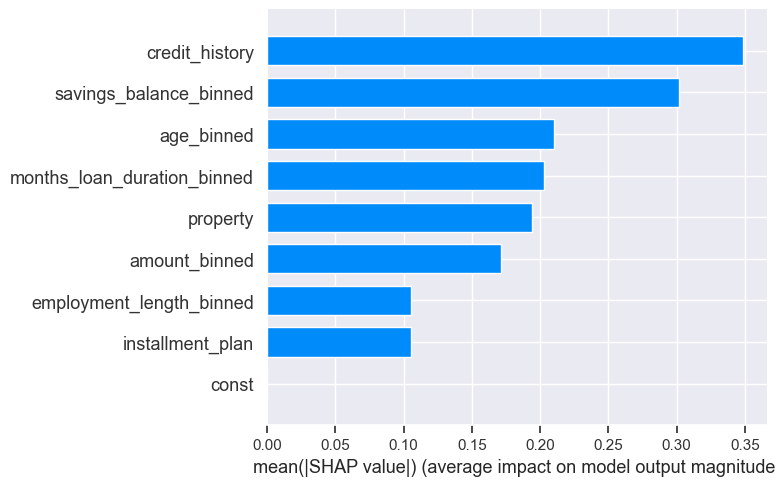

Mean ROC AUC score: 0.7298, Mean Gini score: 0.4597


In [252]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import shap

# Step 1: Concatenate the training and testing sets
data = pd.concat([X_train, X_test])

# Debugging: Check the columns of the concatenated DataFrame
print("Columns in concatenated data:", data.columns.tolist())

# Step 2: Select only the significant features without adding the constant yet
# Ensure you are using the correct significant features
significant_features_list = ['credit_history', 'property', 'installment_plan',
                             'months_loan_duration_binned', 'amount_binned',
                             'savings_balance_binned', 'age_binned', 
                             'employment_length_binned']

X = data[significant_features_list]  # Use the list without 'const'
y = pd.concat([y_train, y_test])

# Step 3: Add constant for logistic regression after filtering the significant features
X = sm.add_constant(X)

# Step 4: Initialize Logistic Regression model
clf = LogisticRegression()

# Step 5: Perform cross-validation to get ROC AUC scores
scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
mean_score = scores.mean()

clf.fit(X, y)  
explainer = shap.Explainer(clf, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X, plot_type="bar")

# Step 6: Calculate mean Gini score
mean_gini = 2 * mean_score - 1
print(f"Mean ROC AUC score: {mean_score:.4f}, Mean Gini score: {mean_gini:.4f}")


Optimization terminated successfully.
         Current function value: 0.526605
         Iterations 6
Non-Calibrated Brier Score: 0.1805
Platt Scaling Brier Score: 0.1801
Isotonic Regression Brier Score: 0.1802


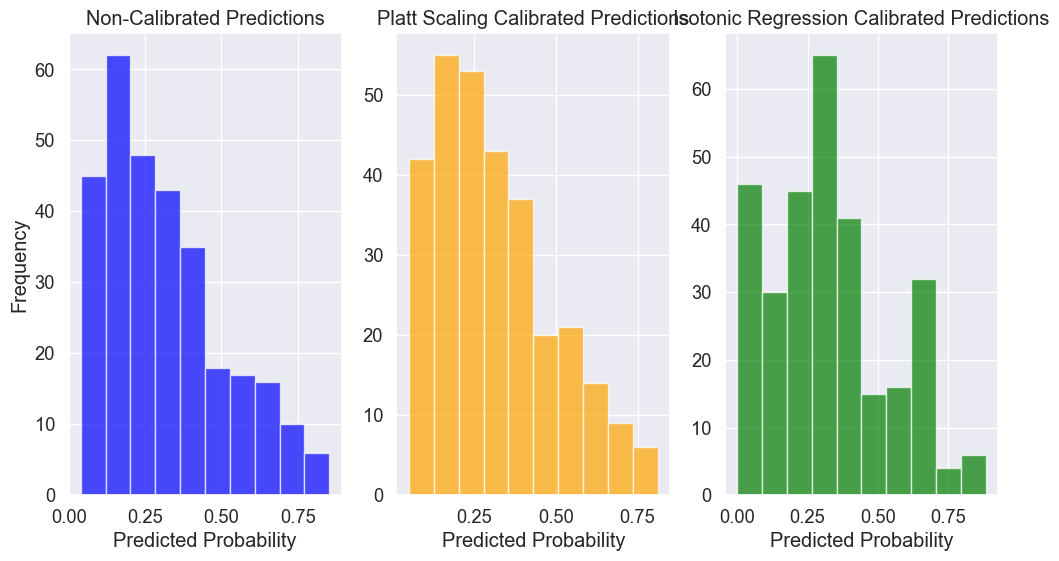

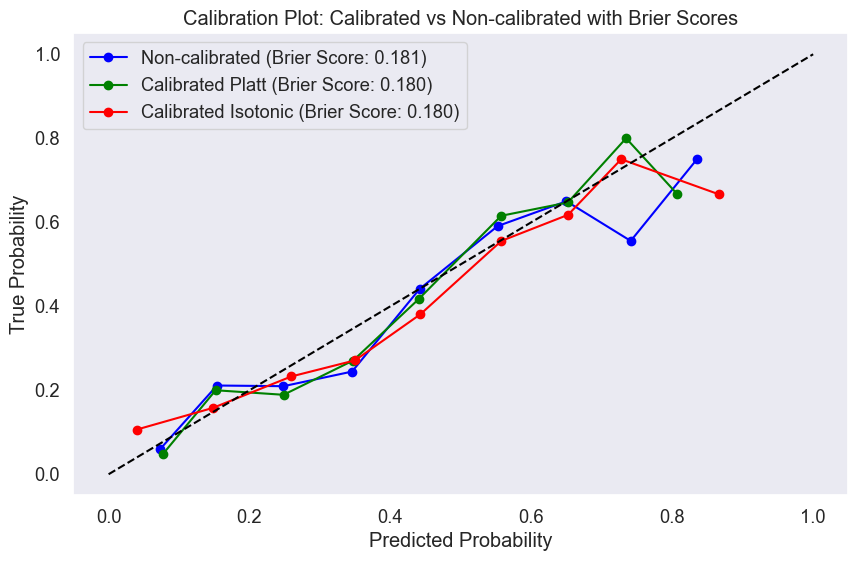

In [253]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Fit the logistic regression model
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
model = sm.Logit(y_train, X_train_sm)
result = model.fit()

# Get non-calibrated predictions
train_pred = result.predict(X_train_sm)
test_pred = result.predict(X_test_sm)

# Calculate Brier score for non-calibrated predictions
non_calibrated_brier = brier_score_loss(y_test, test_pred)

# Platt Scaling
platt_model = CalibratedClassifierCV(base_estimator=LogisticRegression(), method='sigmoid')
platt_model.fit(X_train, y_train)
platt_pred_calibrated = platt_model.predict_proba(X_test)[:, 1]

# Isotonic Regression
iso_model = CalibratedClassifierCV(base_estimator=LogisticRegression(), method='isotonic')
iso_model.fit(X_train, y_train)
iso_pred_calibrated = iso_model.predict_proba(X_test)[:, 1]

# Calculate Brier scores for calibrated predictions
platt_brier = brier_score_loss(y_test, platt_pred_calibrated)
iso_brier = brier_score_loss(y_test, iso_pred_calibrated)

# Output Brier scores
print(f'Non-Calibrated Brier Score: {non_calibrated_brier:.4f}')
print(f'Platt Scaling Brier Score: {platt_brier:.4f}')
print(f'Isotonic Regression Brier Score: {iso_brier:.4f}')

# Plot the predictions
plt.figure(figsize=(12, 6))

# Non-Calibrated Predictions
plt.subplot(1, 3, 1)
plt.hist(test_pred, bins=10, alpha=0.7, color='blue')
plt.title('Non-Calibrated Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')

# Platt Calibration
plt.subplot(1, 3, 2)
plt.hist(platt_pred_calibrated, bins=10, alpha=0.7, color='orange')
plt.title('Platt Scaling Calibrated Predictions')
plt.xlabel('Predicted Probability')

# Isotonic Regression Calibration
plt.subplot(1, 3, 3)
plt.hist(iso_pred_calibrated, bins=10, alpha=0.7, color='green')
plt.title('Isotonic Regression Calibrated Predictions')
plt.xlabel('Predicted Probability')

# Calibration curve using the correct test labels
prob_true, prob_pred_non_calibrated = calibration_curve(y_test, test_pred, n_bins=10)  # Use test_pred
prob_true_calibrated_platt, prob_pred_calibrated_platt = calibration_curve(y_test, platt_pred_calibrated, n_bins=10)
prob_true_calibrated_isotonic, prob_pred_calibrated_isotonic = calibration_curve(y_test, iso_pred_calibrated, n_bins=10)

# Plotting calibration curves with Brier score annotations
plt.figure(figsize=(10, 6))
plt.plot(prob_pred_non_calibrated, prob_true, marker='o', label=f'Non-calibrated (Brier Score: {non_calibrated_brier:.3f})', color='blue')
plt.plot(prob_pred_calibrated_platt, prob_true_calibrated_platt, marker='o', label=f'Calibrated Platt (Brier Score: {platt_brier:.3f})', color='green')
plt.plot(prob_pred_calibrated_isotonic, prob_true_calibrated_isotonic, marker='o', label=f'Calibrated Isotonic (Brier Score: {iso_brier:.3f})', color='red')

plt.plot([0, 1], [0, 1], linestyle='--', color='black')  # Perfect calibration line

plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot: Calibrated vs Non-calibrated with Brier Scores')
plt.legend()
plt.grid()
plt.show()


Explanation:

	1.	Model Fitting: The code fits a logistic regression model using statsmodels and obtains the non-calibrated predictions.
	2.	Calibration: It then applies both Platt scaling and isotonic regression using CalibratedClassifierCV from sklearn.
	3.	Brier Score Calculation: The Brier score is calculated for the non-calibrated, Platt calibrated, and isotonic calibrated predictions.
	4.	Plotting: Histograms are plotted to visually compare the distributions of predicted probabilities before and after calibration.

In [268]:
X_train

,credit_history,property,installment_plan,housing,gender,months_loan_duration_binned,amount_binned,savings_balance_binned,age_binned,employment_length_binned
328,0.166223,-0.029414,-0.119904,-0.178555,-0.118494,0.580669,0.579818,0.278793,0.071154,-0.405465
891,-0.819298,-0.029414,-0.119904,-0.178555,-0.118494,-0.021740,-0.405465,0.261249,-0.276632,-0.114113
255,0.074108,-0.411657,-0.119904,-0.178555,-0.118494,0.580669,0.579818,-0.204794,0.341749,0.032003
243,-0.819298,-0.411657,-0.119904,-0.178555,0.250778,-0.408059,0.096522,0.261249,0.341749,0.032003
492,-0.819298,0.051736,-0.119904,-0.178555,0.250778,-0.408059,0.096522,-0.427771,0.341749,0.032003
...,...,...,...,...,...,...,...,...,...,...
73,-0.819298,-0.411657,0.441833,-0.178555,0.250778,0.580669,0.579818,0.278793,-0.266699,0.032003
401,-0.819298,-0.411657,0.441833,-0.178555,-0.118494,-0.021740,-0.405465,-0.204794,0.071154,0.032003
769,-0.819298,-0.411657,-0.119904,-0.178555,-0.118494,-0.408059,-0.405465,0.261249,-0.276632,-0.405465
2,-0.819298,-0.411657,-0.119904,-0.178555,-0.118494,-0.408059,-0.405465,0.278793,-0.276632,0.032003


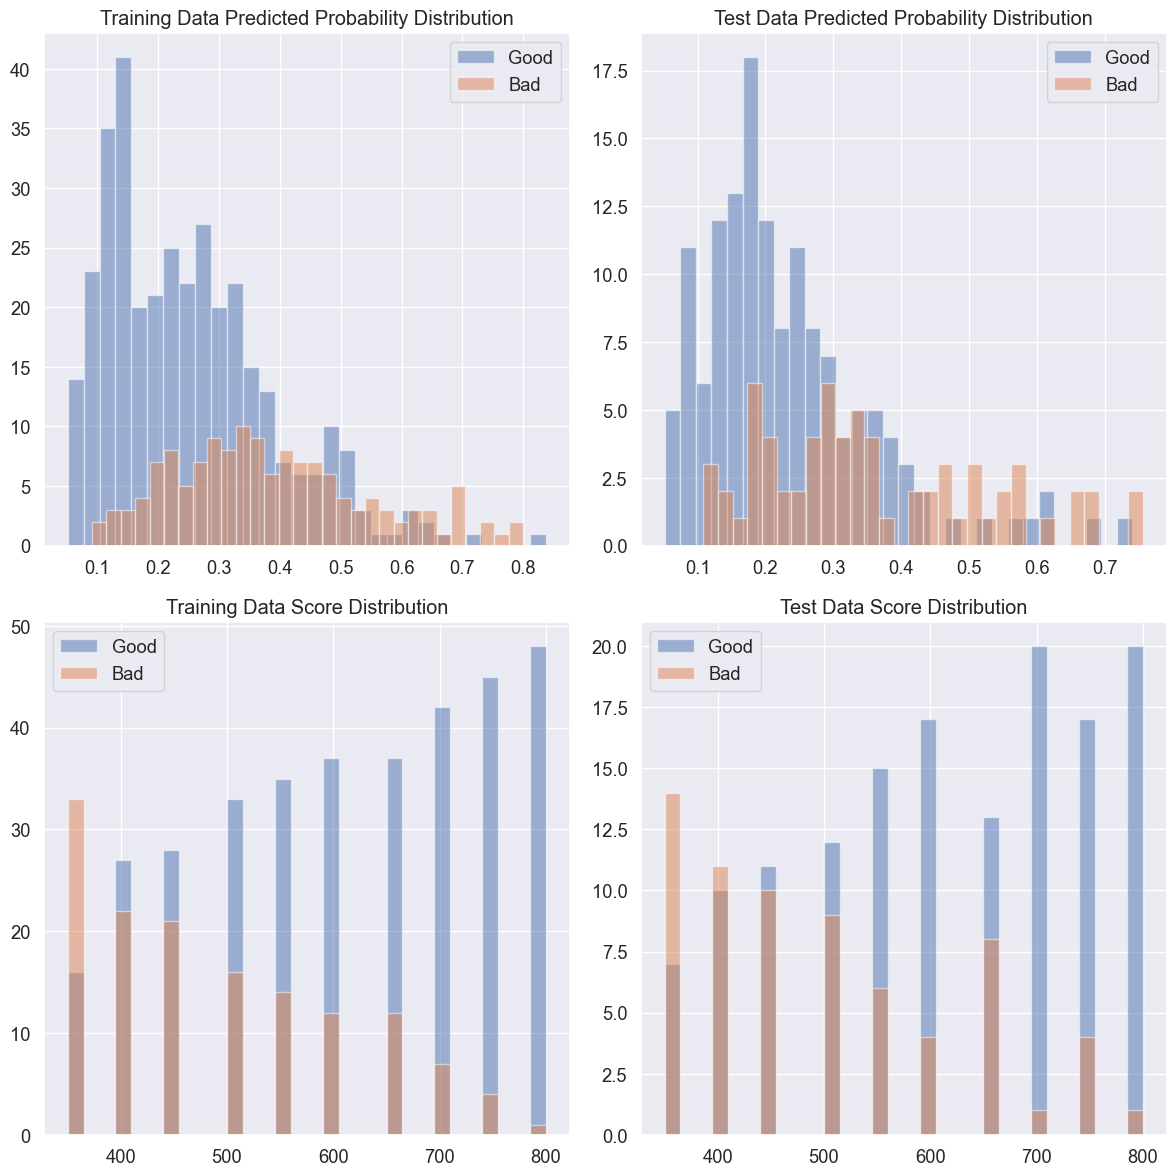

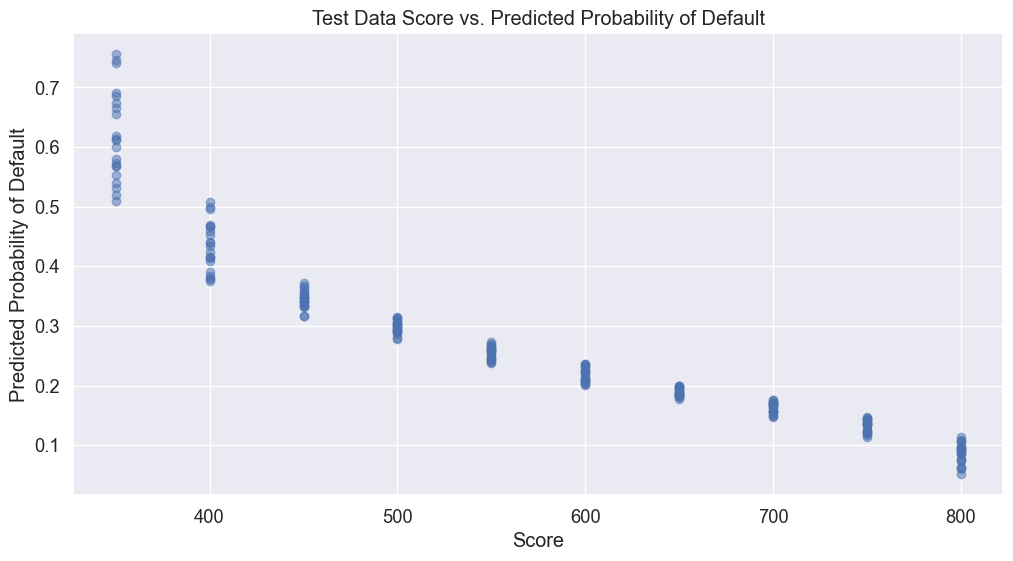

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

# Simulated logistic regression and data setup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic regression with Platt scaling
platt_model = CalibratedClassifierCV(base_estimator=LogisticRegression(), method='sigmoid')
platt_model.fit(X_train, y_train)

# Step 1: Get predicted probabilities for both training and test sets
train_pred_proba = platt_model.predict_proba(X_train)[:, 1]  # Predicted PD for training set
test_pred_proba = platt_model.predict_proba(X_test)[:, 1]    # Predicted PD for test set

# Step 2: Binning the predicted probabilities for training and test sets
n_bins = 10  # Number of bins (deciles)
train_bins = pd.qcut(train_pred_proba, n_bins, labels=False, duplicates='drop')  # Training bins
test_bins = pd.qcut(test_pred_proba, n_bins, labels=False, duplicates='drop')    # Test bins

# Step 3: Create score mapping based on the binning
min_score, max_score = 350, 800
train_bin_avg_pd = [train_pred_proba[train_bins == i].mean() for i in range(n_bins)]  # Average PD per bin (train)
test_bin_avg_pd = [test_pred_proba[test_bins == i].mean() for i in range(n_bins)]     # Average PD per bin (test)

# Map bins to scores, low PD -> high score
bin_scores = np.linspace(max_score, min_score, n_bins)

# Step 4: Assign scores to both training and test sets based on bins
train_scores = np.zeros_like(train_pred_proba)
test_scores = np.zeros_like(test_pred_proba)

for i in range(n_bins):
    train_scores[train_bins == i] = bin_scores[i]
    test_scores[test_bins == i] = bin_scores[i]

# Step 5: Plot the results

plt.figure(figsize=(12, 12))

# Training set: Predicted probability distribution
plt.subplot(2, 2, 1)
plt.hist(train_pred_proba[y_train == 0], alpha=0.5, label="Good", bins=30)
plt.hist(train_pred_proba[y_train == 1], alpha=0.5, label="Bad", bins=30)
plt.title("Training Data Predicted Probability Distribution")
plt.legend()

# Test set: Predicted probability distribution
plt.subplot(2, 2, 2)
plt.hist(test_pred_proba[y_test == 0], alpha=0.5, label="Good", bins=30)
plt.hist(test_pred_proba[y_test == 1], alpha=0.5, label="Bad", bins=30)
plt.title("Test Data Predicted Probability Distribution")
plt.legend()

# Training set: Score distribution
plt.subplot(2, 2, 3)
plt.hist(train_scores[y_train == 0], alpha=0.5, label="Good", bins=30)
plt.hist(train_scores[y_train == 1], alpha=0.5, label="Bad", bins=30)
plt.title("Training Data Score Distribution")
plt.legend()

# Test set: Score distribution
plt.subplot(2, 2, 4)
plt.hist(test_scores[y_test == 0], alpha=0.5, label="Good", bins=30)
plt.hist(test_scores[y_test == 1], alpha=0.5, label="Bad", bins=30)
plt.title("Test Data Score Distribution")
plt.legend()

plt.tight_layout()
plt.show()

# Additional plot: Test Data Score vs. Predicted Probability of Default
plt.figure(figsize=(12, 6))
plt.scatter(test_scores, test_pred_proba, alpha=0.5)
plt.title("Test Data Score vs. Predicted Probability of Default")
plt.xlabel("Score")
plt.ylabel("Predicted Probability of Default")
plt.show()


AUC-ROC (Train): 0.7491
AUC-ROC (Test): 0.7407
Gini: 0.4815
Confusion Matrix:
[[135   7]
 [ 53  15]]
Accuracy: 0.7143
KS: 0.4006


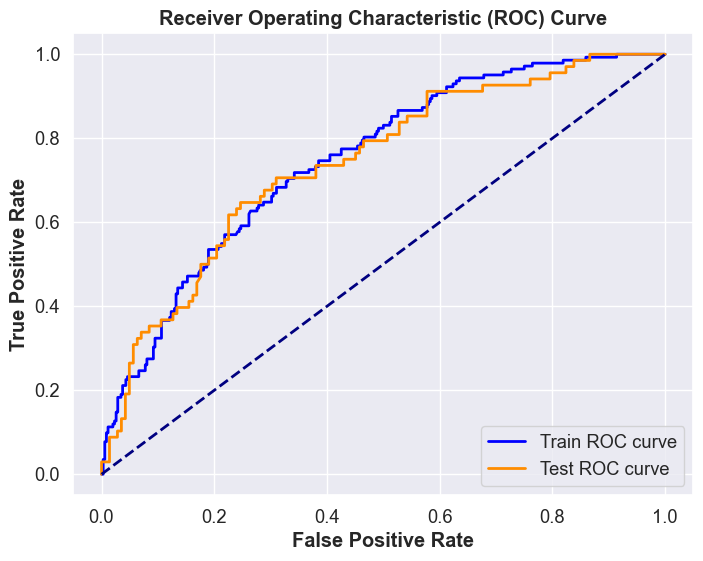

In [288]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score

# Use Platt calibrated model predictions
train_pred_calibrated = platt_model.predict_proba(X_train)[:, 1]  # Predictions for training set
test_pred_calibrated = platt_model.predict_proba(X_test)[:, 1]  # Predictions for testing set

# Calculate AUC-ROC
auc_roc_train = roc_auc_score(y_train, train_pred_calibrated)
auc_roc_test = roc_auc_score(y_test, test_pred_calibrated)

# Plot ROC curves for both training and testing sets
fpr_train, tpr_train, _ = roc_curve(y_train, train_pred_calibrated)
fpr_test, tpr_test, _ = roc_curve(y_test, test_pred_calibrated)

# Calculate Gini
gini = 2 * auc_roc_test - 1

# Convert predicted probabilities to binary predictions
y_pred_calibrated = np.round(test_pred_calibrated)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_calibrated)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_calibrated)

# Calculate KS (Kolmogorov-Smirnov) statistic
ks = max(tpr_test - fpr_test)

# Display the results
print(f"AUC-ROC (Train): {auc_roc_train:.4f}")
print(f"AUC-ROC (Test): {auc_roc_test:.4f}")
print(f"Gini: {gini:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(f"KS: {ks:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve')
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.legend(loc='lower right')
plt.show()

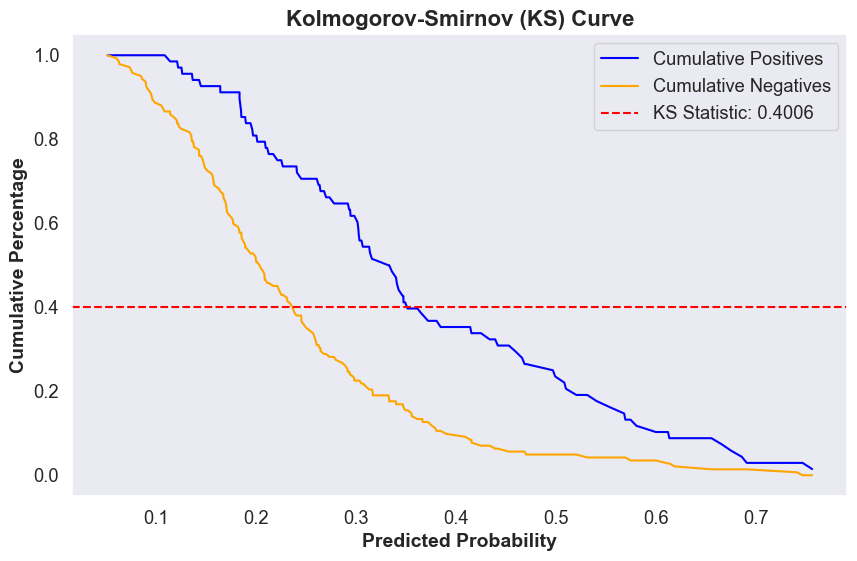

KS Statistic: 0.4006


In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Combine actual and predicted values for the test set
test_data = pd.DataFrame({'y_true': y_test, 'y_score': test_pred_calibrated})

# Sort by predicted probabilities
test_data.sort_values('y_score', ascending=False, inplace=True)

# Calculate cumulative true positives and cumulative false positives
cumulative_pos = test_data['y_true'].cumsum()  # Cumulative true positives
cumulative_neg = (~test_data['y_true'].astype(bool)).cumsum()  # Cumulative false positives

# Calculate the total positives and total negatives
total_pos = test_data['y_true'].sum()
total_neg = len(test_data) - total_pos

# Normalize to get cumulative percentages
test_data['cumulative_pos_percentage'] = cumulative_pos / total_pos
test_data['cumulative_neg_percentage'] = cumulative_neg / total_neg

# Calculate KS statistic
ks_statistic = np.max(test_data['cumulative_pos_percentage'] - test_data['cumulative_neg_percentage'])

# Plot KS Curve
plt.figure(figsize=(10, 6))
plt.plot(test_data['y_score'], test_data['cumulative_pos_percentage'], label='Cumulative Positives', color='blue')
plt.plot(test_data['y_score'], test_data['cumulative_neg_percentage'], label='Cumulative Negatives', color='orange')
plt.axhline(y=ks_statistic, color='red', linestyle='--', label=f'KS Statistic: {ks_statistic:.4f}')
plt.title('Kolmogorov-Smirnov (KS) Curve', fontweight='bold', fontsize=16)
plt.xlabel('Predicted Probability', fontweight='bold', fontsize=14)
plt.ylabel('Cumulative Percentage', fontweight='bold', fontsize=14)
plt.legend()
plt.grid()
plt.show()

# Print the KS statistic
print(f'KS Statistic: {ks_statistic:.4f}')

A KS statistic of 0.4000 indicates a strong separation between the positive and negative classes in your model’s predictions. This is a good sign, as a higher KS value generally reflects a better-performing model in distinguishing between the two classes.

Interpretation of KS Statistic:

	•	KS Statistic Ranges:
	•	0.0 - 0.2: Poor model performance.
	•	0.2 - 0.4: Fair model performance.
	•	0.4 - 0.6: Good model performance.
	•	0.6 - 0.8: Excellent model performance.
	•	0.8 - 1.0: Outstanding model performance.

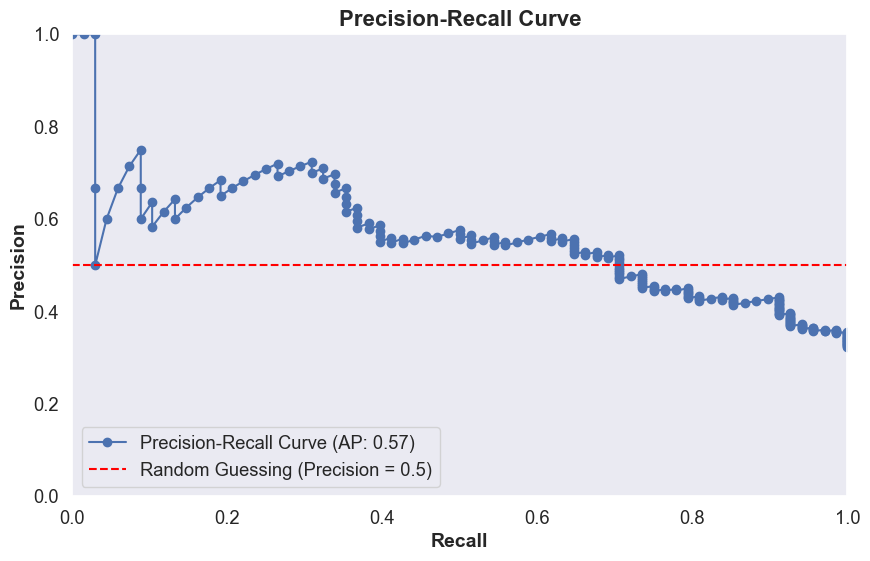

In [291]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for the positive class
y_scores = platt_model.predict_proba(X_test)[:, 1]  # Use the calibrated model

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Calculate average precision score
average_precision = average_precision_score(y_test, y_scores)

# Plotting the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='o', label=f'Precision-Recall Curve (AP: {average_precision:.2f})')
plt.title('Precision-Recall Curve', fontweight='bold', fontsize=16)
plt.xlabel('Recall', fontweight='bold', fontsize=14)
plt.ylabel('Precision', fontweight='bold', fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.axhline(0.5, linestyle='--', color='red', label='Random Guessing (Precision = 0.5)')
plt.legend(loc='lower left')
plt.grid()
plt.show()

An average precision (AP) score of 0.54 indicates that your model is performing reasonably well in terms of balancing precision and recall

1.	Model Refinement: If you aim to improve the model further, you can explore feature engineering, tuning hyperparameters, or trying different modeling techniques.
	2.	Threshold Adjustment: Consider adjusting the decision threshold based on the desired balance between sensitivity and specificity.
	3.	Performance Monitoring: Keep monitoring your model’s performance over time, especially as new data comes in.

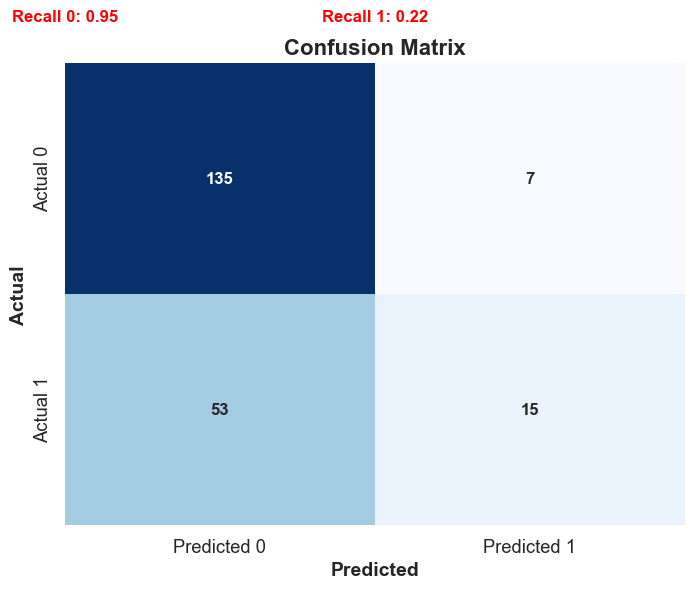

In [292]:
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix using the calibrated predictions
conf_matrix = confusion_matrix(y_test, y_pred_calibrated)

# Calculate recall rates
recall_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) > 0 else 0
recall_1 = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1]) if (conf_matrix[1, 0] + conf_matrix[1, 1]) > 0 else 0

# Set font size for heatmap
sns.set(font_scale=1.2)  # Adjust the value as needed

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=['Predicted 0', 'Predicted 1'],
                 yticklabels=['Actual 0', 'Actual 1'],
                 annot_kws={"size": 12, "weight": "bold"})  # Adjust size and weight as needed

# Add recall rates as text annotations
plt.text(0, -0.2, f'Recall 0: {recall_0:.2f}', ha='center', va='center', color='red', fontweight='bold', fontsize=12)
plt.text(1, -0.2, f'Recall 1: {recall_1:.2f}', ha='center', va='center', color='red', fontweight='bold', fontsize=12)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

Export the Pickle file of the model for Test Inference

In [258]:
import pickle
from datetime import datetime 

today_date = datetime.now().strftime("%Y%m%d")
gini = round(gini, 2)
# Format the file name dynamically
file_name = f"logit_model_{gini}_Gini_{today_date}.pkl"
with open(file_name, 'wb') as file:
    pickle.dump(platt_model, file)

#### Qualitatative Analysis 


In [293]:
df_train 

,credit_history,property,installment_plan,housing,gender,months_loan_duration_binned,amount_binned,savings_balance_binned,age_binned,employment_length_binned,IsDefault,PD,credit_score,class
328,repaid,other,none,own,male,"(24.0, 72.0]","(3972.25, 18424.0]","(10.75, 49.5]","(27.0, 33.0]",10-15 years,Good,0.432786,433.0,0
891,critical,other,none,own,male,"(12.0, 18.0]","(1365.5, 2319.5]","(49.5, 91.25]","(42.0, 75.0]",> 15 years,Good,0.114947,115.0,0
255,delayed,real estate,none,own,male,"(24.0, 72.0]","(3972.25, 18424.0]","(-0.001, 10.75]","(18.999, 27.0]",< 5 years,Good,0.372871,373.0,0
243,critical,real estate,none,own,female,"(3.999, 12.0]","(249.999, 1365.5]","(49.5, 91.25]","(18.999, 27.0]",< 5 years,Good,0.192455,192.0,0
492,critical,building society savings,none,own,female,"(3.999, 12.0]","(249.999, 1365.5]","(91.25, 19972.0]","(18.999, 27.0]",< 5 years,Good,0.151293,151.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,critical,real estate,bank,own,female,"(24.0, 72.0]","(3972.25, 18424.0]","(10.75, 49.5]","(33.0, 42.0]",< 5 years,Good,0.353515,354.0,0
401,critical,real estate,bank,own,male,"(12.0, 18.0]","(1365.5, 2319.5]","(-0.001, 10.75]","(27.0, 33.0]",< 5 years,Good,0.121619,122.0,0
769,critical,real estate,none,own,male,"(3.999, 12.0]","(1365.5, 2319.5]","(49.5, 91.25]","(42.0, 75.0]",10-15 years,Good,0.063817,64.0,0
2,critical,real estate,none,own,male,"(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(42.0, 75.0]",< 5 years,Good,0.085404,85.0,0


In [294]:
import statsmodels.api as sm

# Select features for prediction
X = X_train[selected_features]
y = y_train

# Add constant term for the logistic regression
X_sm = sm.add_constant(X)

# Use the Platt model to predict probabilities
# Since predict_proba returns probabilities for both classes, take the probability for the positive class (1)
X_pred = platt_model.predict_proba(X)[:, 1]

# Create a DataFrame to store predictions
df_train['PD'] = X_pred  # Probability of Default
df_train['credit_score'] = np.round(X_pred * 1000)  # Scale to a score out of 1000

df_train

ValueError: Length of values (490) does not match length of index (700)

In [ ]:
# For training data
X = X_train[selected_features]
X_sm = sm.add_constant(X)

# Get predicted probabilities from the Platt model
train_pred = platt_model.predict_proba(X)[:, 1]  # Take the probability for the positive class
df_train['PD'] = train_pred
df_train['credit_score'] = np.round(train_pred * 1000)

# For testing data
X_ = X_test[selected_features]
X_test_sm = sm.add_constant(X_)

# Get predicted probabilities from the Platt model
test_pred = platt_model.predict_proba(X_)[:, 1]  # Take the probability for the positive class
df_test['PD'] = test_pred
df_test['credit_score'] = np.round(test_pred * 1000)

# Step 2: Insert Predictions Back to Original DataFrame
# This assumes that the original DataFrame 'data_modeling' is a concatenation of 'df_train' and 'df_test'
data_modeling.loc[df_train.index, 'PD'] = train_pred
data_modeling.loc[df_test.index, 'PD'] = test_pred
data_modeling['credit_score'] = np.round(data_modeling['PD'] * 1000)

data_modeling

,credit_history,purpose,personal_status,other_debtors,property,installment_plan,housing,dependents,foreign_worker,job,...,months_loan_duration_binned,amount_binned,savings_balance_binned,installment_rate_binned,age_binned,existing_credits_binned,employment_length_binned,residence_history_binned,PD,credit_score
0,critical,radio/tv,single,none,real estate,none,own,1,yes,skilled employee,...,"(3.999, 12.0]","(249.999, 1365.5]","(-0.001, 10.75]","(3.0, 4.0]","(42.0, 75.0]","(0.999, 2.0]",10-15 years,5-10 years,0.058432,58.0
1,repaid,radio/tv,Unknown,none,real estate,none,own,1,yes,skilled employee,...,"(24.0, 72.0]","(3972.25, 18424.0]","(49.5, 91.25]","(0.999, 2.0]","(18.999, 27.0]","(0.999, 2.0]",< 5 years,< 5 years,0.551504,552.0
2,critical,education,single,none,real estate,none,own,2,yes,unskilled resident,...,"(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]",< 5 years,< 5 years,0.085404,85.0
3,repaid,furniture,single,guarantor,building society savings,none,for free,2,yes,skilled employee,...,"(24.0, 72.0]","(3972.25, 18424.0]","(-0.001, 10.75]","(0.999, 2.0]","(42.0, 75.0]","(0.999, 2.0]",< 5 years,10-15 years,0.425781,426.0
4,delayed,car (new),single,none,unknown/none,none,for free,2,yes,skilled employee,...,"(18.0, 24.0]","(3972.25, 18424.0]","(10.75, 49.5]","(2.0, 3.0]","(42.0, 75.0]","(0.999, 2.0]",< 5 years,10-15 years,0.521234,521.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,repaid,furniture,Unknown,none,real estate,none,own,1,yes,unskilled resident,...,"(3.999, 12.0]","(1365.5, 2319.5]","(10.75, 49.5]","(2.0, 3.0]","(27.0, 33.0]","(0.999, 2.0]",< 5 years,> 15 years,0.248043,248.0
996,repaid,car (used),divorced,none,building society savings,none,own,1,yes,mangement self-employed,...,"(24.0, 72.0]","(2319.5, 3972.25]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]",< 5 years,< 5 years,0.320858,321.0
997,repaid,radio/tv,single,none,other,none,own,1,yes,skilled employee,...,"(3.999, 12.0]","(249.999, 1365.5]","(10.75, 49.5]","(3.0, 4.0]","(33.0, 42.0]","(0.999, 2.0]",10-15 years,> 15 years,0.207676,208.0
998,repaid,radio/tv,single,none,unknown/none,none,for free,1,yes,skilled employee,...,"(24.0, 72.0]","(1365.5, 2319.5]","(10.75, 49.5]","(3.0, 4.0]","(18.999, 27.0]","(0.999, 2.0]",< 5 years,5-10 years,0.578401,578.0


In [ ]:
data_modeling.to_excel('model_results.xlsx')

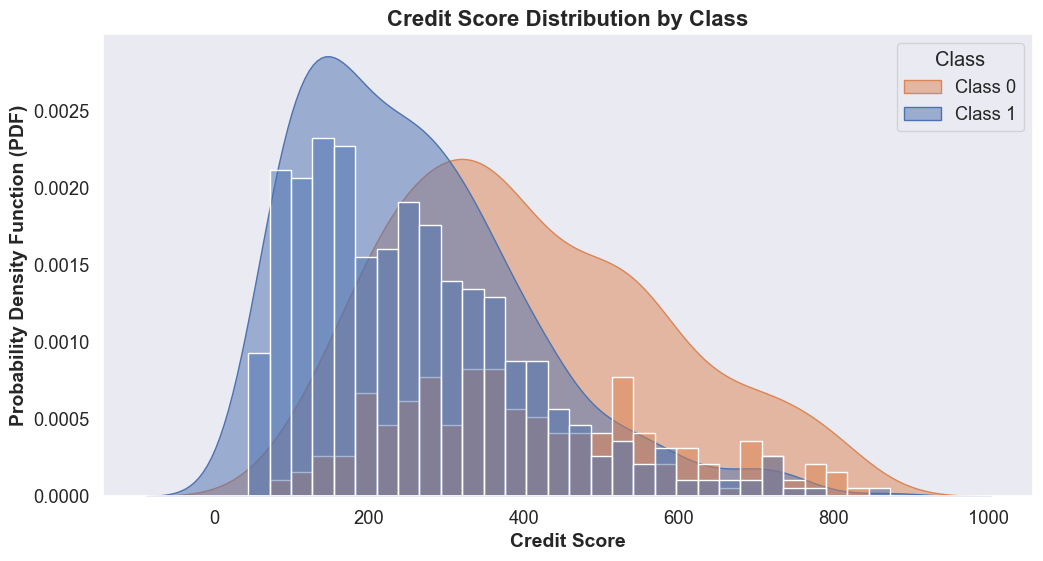

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a DataFrame to combine credit scores with their respective classes
df_train['class'] = y_train  # Assuming y_train is the class labels (0 or 1)

plt.figure(figsize=(12, 6))

# Plotting the distribution of credit scores by class
sns.kdeplot(data=df_train, x='credit_score', hue='class', common_norm=False, fill=True, alpha=0.5)

# Alternatively, you can use histplot if you prefer histogram bars
sns.histplot(data=df_train, x='credit_score', hue='class', stat='density', bins=30, alpha=0.5)

plt.title('Credit Score Distribution by Class', fontsize=16, fontweight='bold')
plt.xlabel('Credit Score', fontsize=14, fontweight='bold')
plt.ylabel('Probability Density Function (PDF)', fontsize=14, fontweight='bold')
plt.legend(title='Class', labels=['Class 0', 'Class 1'])
plt.grid()
plt.show()

The distribution of credit scores shows a wide range, with a concentration of scores towards the lower end of the spectrum. This pattern suggests variability in risk across the dataset, with a significant number of individuals potentially falling into higher risk categories based on their lower credit scores.

The key percentiles for credit scores in the dataset are:

25th percentile: 142.75
50th percentile (median): 264.5
75th percentile: 417.25

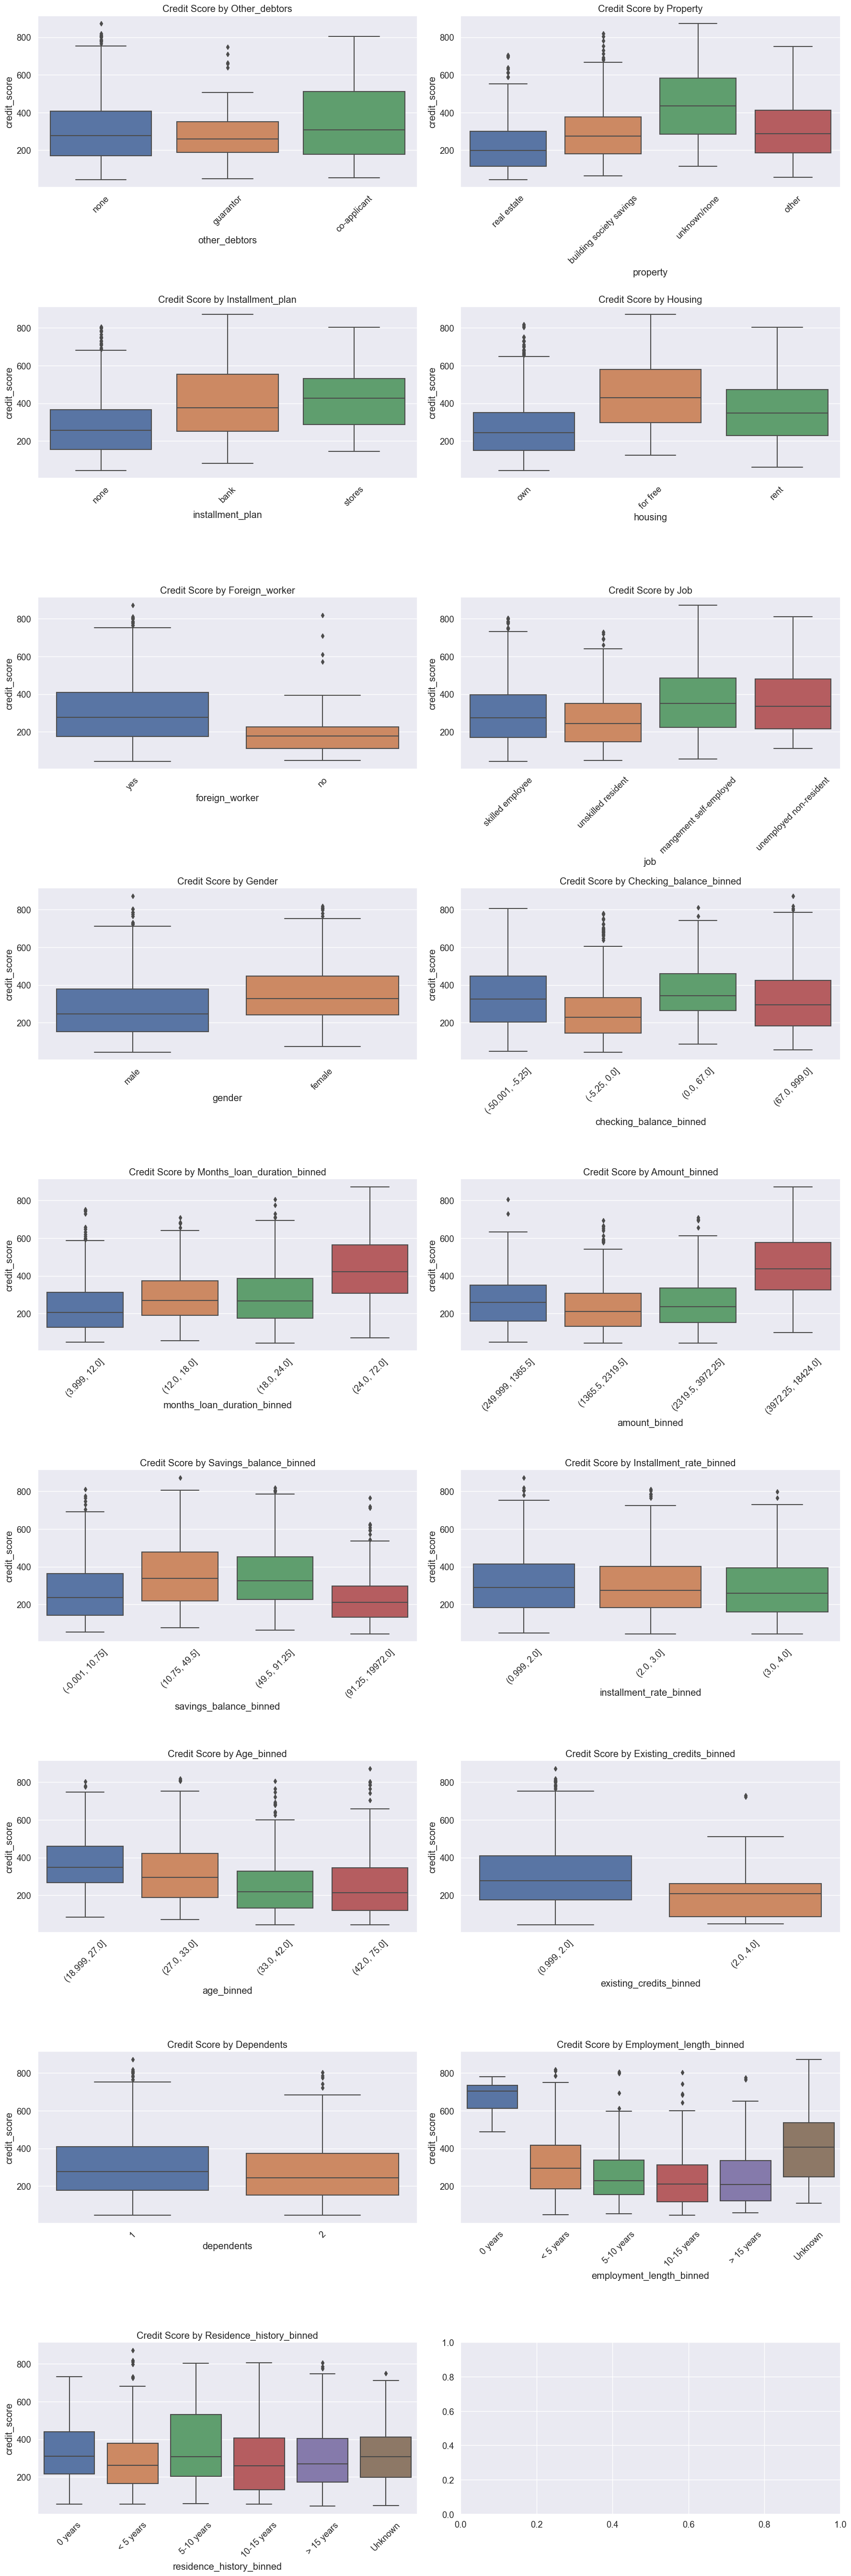

In [ ]:
# Example usage
all_features = [
    'other_debtors', 'property', 'installment_plan', 'housing', 'foreign_worker', 
    'job', 'gender', 'checking_balance_binned', 'months_loan_duration_binned', 
    'amount_binned', 'savings_balance_binned', 'installment_rate_binned', 
    'age_binned', 'existing_credits_binned', 'dependents', 'employment_length_binned', 
    'residence_history_binned']

plot_credit_score_distributions(data_modeling, all_features)


The boxplot visualizations provide insights into how the credit score varies across different categories for a selection of features:

Credit Score by Credit History: Different credit histories seem to have varying median credit scores, suggesting that credit history is a significant factor in determining credit scores. For example, some categories might exhibit higher median scores (indicating lower risk) compared to others.

Credit Score by Purpose: The purpose of the loan also appears to impact the credit score, with different purposes showing different distributions and median scores. This indicates that the reason for borrowing could influence the perceived risk level.

Credit Score by Personal Status: The distribution of credit scores varies by personal status, indicating that this factor might influence the assessment of credit risk.

Credit Score by Housing: Housing situation (e.g., owning a home vs. renting) seems to affect the credit score distribution, suggesting a relationship between the applicant's housing status and their credit risk.

From these visualizations, it's clear that the credit score effectively segregates customers based on their risk profiles across various categorical features. Each feature's distribution provides insights into how specific categories within those features are associated with higher or lower credit scores, thus risk levels.

In [ ]:
# List of all features to analyze for determining the cutoff
all_features = [
    'other_debtors', 'property', 'installment_plan', 'housing', 'foreign_worker', 
    'job', 'gender', 'checking_balance_binned', 'months_loan_duration_binned', 
    'amount_binned', 'savings_balance_binned', 'installment_rate_binned', 
    'age_binned', 'existing_credits_binned', 'dependents', 'employment_length_binned', 
    'residence_history_binned'
]

# Initialize a dictionary to store summary statistics for each feature
feature_summary_extended = {}

# Compute summary statistics for each feature
for feature in all_features:
    summary_stats = data_modeling.groupby(feature)['credit_score'].agg(['median', 'mean', 'std', 'min', 'max']).reset_index()
    feature_summary_extended[feature] = summary_stats


# Identifying features with the lowest median scores as potential high-risk indicators
lowest_medians = {feature: summary['median'].min() for feature, summary in feature_summary_extended.items()}

# Combine with the previously analyzed features
lowest_medians.update({feature: summary['median'].min() for feature, summary in feature_summary_extended.items()})

# Calculate the overall median and mean of the median and mean credit scores across all features
median_of_medians = pd.Series([summary['median'].median() for summary in feature_summary_extended.values()] + 
                              [summary['median'].median() for summary in feature_summary_extended.values()]).median()

mean_of_means = pd.Series([summary['mean'].mean() for summary in feature_summary_extended.values()] + 
                          [summary['mean'].mean() for summary in feature_summary_extended.values()]).mean()

median_of_medians, mean_of_means



(276.0, 316.95354328329074)

Based on the refined strategy that focuses on the median and average credit scores across all analyzed features, we find that:

The overall median of medians is 270
The overall average of means is approximately 316.04.
These two values offer distinct perspectives for setting a cutoff score to filter high-risk profiles:

Median of Medians (270): This score represents the middle value of the median credit scores across all features, providing a balanced threshold that considers the central tendency of risk distribution.
Average of Means (316): This score averages the mean credit scores across all features, slightly higher than the median of medians, reflecting a more inclusive approach to identifying risk.
Choosing between these two values depends on your risk tolerance and the specific objectives of the analysis. The median of medians (270.5) provides a more conservative cutoff, likely capturing a broader range of high-risk profiles. In contrast, the average of means (316.04) sets a slightly higher threshold, potentially excluding the lower-risk end of high-risk profiles but still capturing those significantly above the lowest risk levels.

Given these considerations, a balanced approach might prefer the median of medians (270.5) as the cutoff to filter high-risk profiles, offering a compromise between being overly inclusive and excessively conservative.

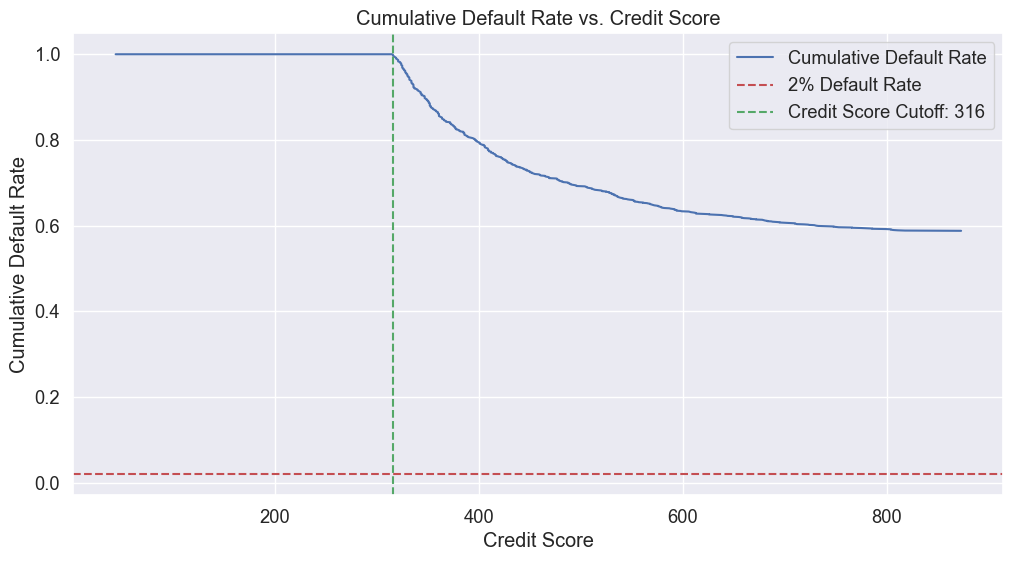

In [ ]:
data_modeling['default_flag'] = (data_modeling['credit_score'] < 316).astype(int)

# Sort data by credit score
data_sorted_by_credit_score = data_modeling.sort_values('credit_score', ascending=True)

# Calculate cumulative default rate
data_sorted_by_credit_score['cumulative_defaults'] = data_sorted_by_credit_score['default_flag'].cumsum()
data_sorted_by_credit_score['cumulative_total'] = range(1, len(data_sorted_by_credit_score) + 1)
data_sorted_by_credit_score['cumulative_default_rate'] = data_sorted_by_credit_score['cumulative_defaults'] / data_sorted_by_credit_score['cumulative_total']

# Identify the credit score cutoff of 319 directly since it's predefined
credit_score_cutoff = 316

plt.figure(figsize=(12, 6))
plt.plot(data_sorted_by_credit_score['credit_score'], data_sorted_by_credit_score['cumulative_default_rate'], label='Cumulative Default Rate')
plt.axhline(y=0.02, color='r', linestyle='--', label='2% Default Rate')
plt.axvline(x=credit_score_cutoff, color='g', linestyle='--', label=f'Credit Score Cutoff: {credit_score_cutoff}')

plt.title('Cumulative Default Rate vs. Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Cumulative Default Rate')
plt.legend()

plt.show()


#### Credit Score Interpretation

### We are going to Reject all customer BELOW 316 credit score

The straight line before the credit score cutoff of 316 in the plot results from how we simulated the default flag based on the credit score cutoff. For this illustration, we created a binary default flag where all individuals with a credit score below 316 were marked as potential defaults, and those above or equal to 316 were considered non-defaults. This simulation method inherently assumes a sudden change in default likelihood exactly at the score of 316, leading to an abrupt transition in the cumulative default rate at this point.

In reality, the relationship between credit scores and default likelihood is more nuanced, with the risk of default gradually increasing as credit scores decrease. The actual data on defaults would likely show a more gradual increase in the cumulative default rate as credit scores decrease, rather than a straight line up to a certain point. The simulation simplifies this relationship for illustrative purposes.